# Plot Figure 10

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import cftime
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import netCDF4 as nc
import os
from pathlib import Path
from itertools import cycle

# Handy metpy tutorial working with xarray:
# https://unidata.github.io/MetPy/latest/tutorials/xarray_tutorial.html#sphx-glr-tutorials-xarray-tutorial-py
import metpy.calc as mpcalc
from metpy.units import units

In [2]:
file_path = Path("data/")
files = list(file_path.glob("*fig10*"))
#files = os.listdir(Path("data/*fig10*"))
#files.remove('GFDL-CM4-piControl-fig10.nc') # this one doesnt work, need to debug
files

[PosixPath('data/MRI-ESM2-0-historical-fig10.nc'),
 PosixPath('data/SAM0-UNICON-historical-fig10.nc'),
 PosixPath('data/MPI-ESM1-2-HR-historical-fig10.nc'),
 PosixPath('data/ACCESS-CM2-historical-fig10.nc'),
 PosixPath('data/GFDL-CM4-historical-fig10.nc'),
 PosixPath('data/MIROC6-historical-fig10.nc'),
 PosixPath('data/CNRM-ESM2-1-historical-fig10.nc'),
 PosixPath('data/MIROC-ES2L-historical-fig10.nc'),
 PosixPath('data/KACE-1-0-G-historical-fig10.nc'),
 PosixPath('data/ACCESS-ESM1-5-historical-fig10.nc'),
 PosixPath('data/EC-Earth3-historical-fig10.nc'),
 PosixPath('data/EC-Earth3-AerChem-historical-fig10.nc'),
 PosixPath('data/EC-Earth3-Veg-LR-historical-fig10.nc'),
 PosixPath('data/GFDL-CM4-piControl-fig10.nc'),
 PosixPath('data/AWI-ESM-1-1-LR-historical-fig10.nc'),
 PosixPath('data/CNRM-CM6-1-HR-historical-fig10.nc'),
 PosixPath('data/MPI-ESM-1-2-HAM-historical-fig10.nc'),
 PosixPath('data/HadGEM3-GC31-LL-historical-fig10.nc'),
 PosixPath('data/MPI-ESM1-2-LR-historical-fig10.nc'),


In [3]:
ps = 100000 * units.Pa # temporary hack, should interpolate pressure from daily timeseries

data/SAM0-UNICON-historical-fig10.nc failed


/srv/conda/envs/notebook/lib/python3.9/site-packages/metpy/calc/thermo.py:1078: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')
/srv/conda/envs/notebook/lib/python3.9/site-packages/metpy/calc/thermo.py:1078: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')
/srv/conda/envs/notebook/lib/python3.9/site-packages/metpy/calc/thermo.py:1078: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')
/srv/conda/envs/notebook/lib/python3.9/site-packages/metpy/calc/thermo.py:1078: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')


data/KACE-1-0-G-historical-fig10.nc failed


/srv/conda/envs/notebook/lib/python3.9/site-packages/metpy/calc/thermo.py:1078: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')
/srv/conda/envs/notebook/lib/python3.9/site-packages/metpy/calc/thermo.py:1078: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')
/srv/conda/envs/notebook/lib/python3.9/site-packages/metpy/calc/thermo.py:1078: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')


data/GFDL-CM4-piControl-fig10.nc failed


/srv/conda/envs/notebook/lib/python3.9/site-packages/metpy/calc/thermo.py:1078: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')
/srv/conda/envs/notebook/lib/python3.9/site-packages/metpy/calc/thermo.py:1078: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')
/srv/conda/envs/notebook/lib/python3.9/site-packages/metpy/calc/thermo.py:1078: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')
/srv/conda/envs/notebook/lib/python3.9/site-packages/metpy/calc/thermo.py:1078: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')
/srv/conda/envs/notebook/lib/python3.9/site-packages/metpy/calc/thermo.py:1078: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ens

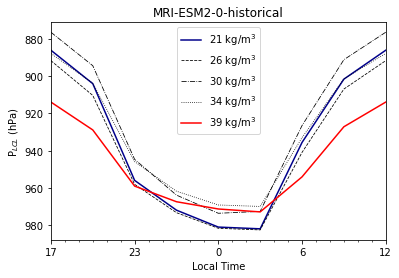

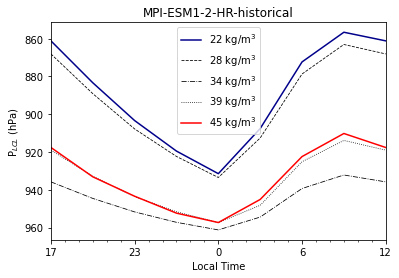

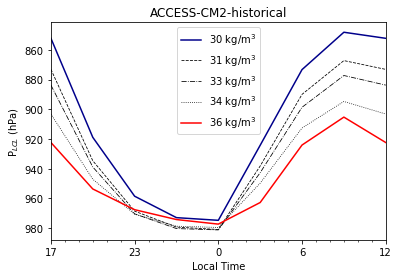

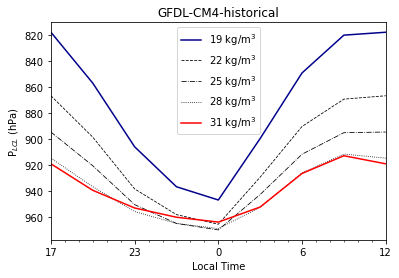

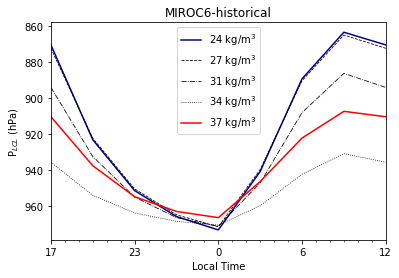

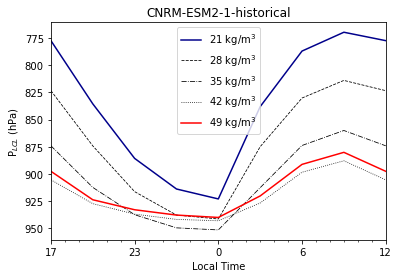

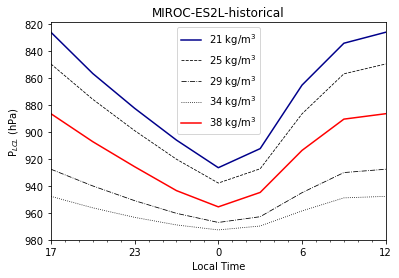

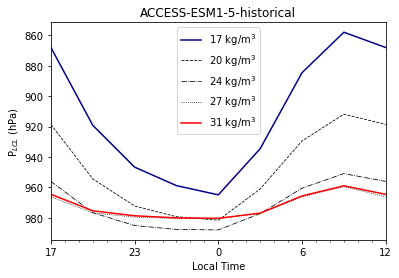

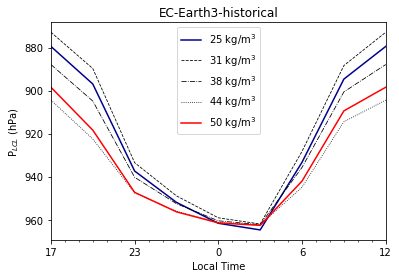

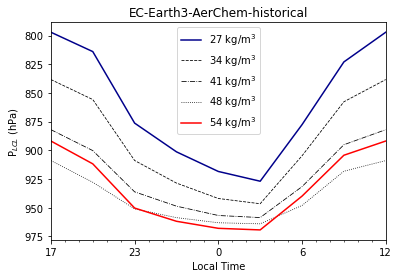

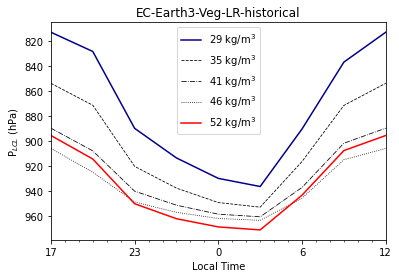

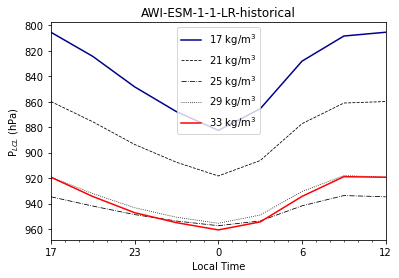

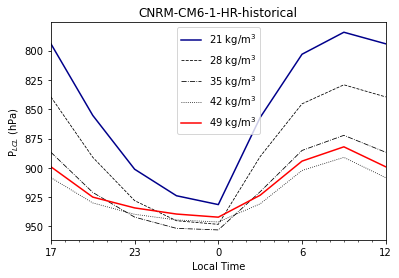

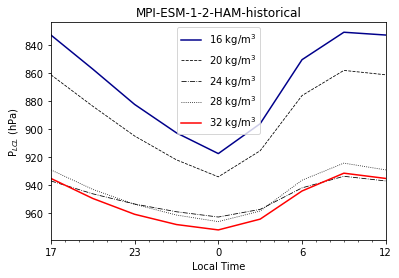

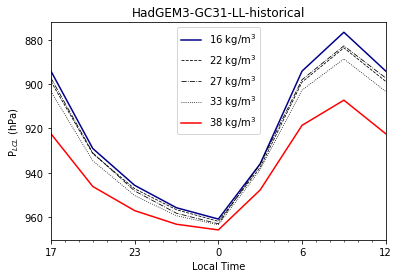

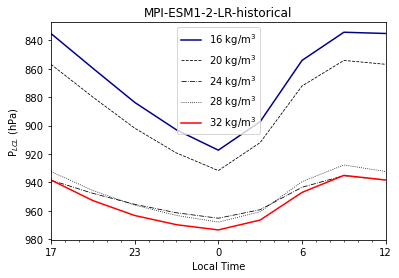

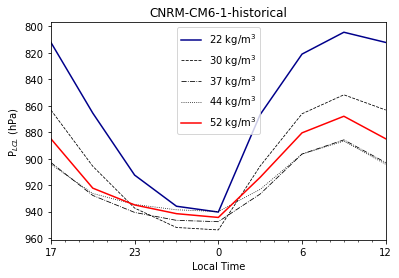

In [14]:
for data in files:
    try:
        # open the data and re-convert time to cftime so xarray is happy
        data_in = xr.open_dataset(data, engine="netcdf4", decode_times=False).metpy.quantify()
        #data_in["time"] = cftime.num2date(data_in.time, "hours since 1850-01-01 00:00:00", calendar="noleap", has_year_zero=True)
        data_in["time"] = cftime.num2date(data_in.time, "hours since 0001-01-01 03:00:00", calendar="noleap", has_year_zero=True)


        # use metpy to convert humidity field to dew point temp
        try:
            data_in["td"] = mpcalc.dewpoint_from_specific_humidity(ps, data_in.tas, data_in.huss)
        except ValueError:
            data_in["tas"] = data_in.tas * units.kelvin
            data_in["td"] = mpcalc.dewpoint_from_specific_humidity(ps, data_in.tas, data_in.huss)

        # compute the spatial average
        spatial_average = data_in.mean(dim=("lat", "lon")).dropna(dim="time")

        # sort the file into 6 groups based on soil moisture content
        the_max = float(spatial_average.mrsos.max().values)
        the_min = float(spatial_average.mrsos.min().values)
        the_range =  the_max - the_min

        spatial_average["soil_moisture_grp"] = ((spatial_average.mrsos / (the_range / 6)).round() * (the_range / 6)).round()

        gbysoil = spatial_average.groupby(spatial_average.soil_moisture_grp)

        # remove the highest and lowest values, they are usually too sparse to plot
        mrsos_keys = list(gbysoil.groups.keys())
        mrsos_keys.remove(max(mrsos_keys))
        mrsos_keys.remove(min(mrsos_keys))

        # calculate and plot the average diurnal cycle of lcl height
        fig, ax = plt.subplots()
        lposition = 1.1 # for annotating plot
        lines = ["--","-.",":"]
        linecycler = cycle(lines)
        for key in mrsos_keys:
            # group by hour
            hourly_data = gbysoil[key].groupby(gbysoil[key].time.dt.hour).mean(dim="time") 

            # find and plot the lcl
            plcl, tlcl = mpcalc.lcl(ps, hourly_data.tas, hourly_data.td)
            plcl_hpa = plcl / 100
            
            # assign colors to match Betts
            
            if key == min(mrsos_keys):
                plot_kwargs = {"color":"darkblue"}
            elif key == max(mrsos_keys):
                plot_kwargs = {"color":"red"}
            else:
                plot_kwargs = {"color":"black", "linestyle":next(linecycler), "linewidth":0.8}

            # append hour 24 to match hour 0
            the_time = np.append(hourly_data.hour.values, 24)
            the_lcl = np.append(plcl_hpa, plcl_hpa[0])
            ax.plot(the_time, the_lcl, label=f"{round(key)} kg/m$^3$", **plot_kwargs)


            #the_label = ax.annotate(f"{round(key)} kg/m$^3$", (24, the_lcl[-1]))
            #lposition -= 1 / 5
            #ax.annotate(f"{round(key)} kg/m$^3$",
            #            xy=(18, the_lcl[-3]), xycoords='data',
            #            xytext=(1.01, lposition), textcoords='axes fraction'),
            #            arrowprops=dict(arrowstyle="->", relpos=(0,0.5)),
            #            horizontalalignment='left', verticalalignment='center')

        # make the plot match Betts fig 11
        plt.gca().invert_yaxis()
        ax.set_xlabel("Local Time")
        ax.set_ylabel("P$_{LCL}$ (hPa)")
        ax.legend(loc="upper center")
        ax.xaxis.set_major_locator(MultipleLocator(6))
        ax.xaxis.set_major_formatter('{x:.0f}')
        ax.xaxis.set_minor_locator(MultipleLocator(1))
        ax.set_xticks((0,6,12,18,24), labels=(17, 23, 0, 6, 12))

        ax.set_xlim(0,24)
        ax.set_title(str(data)[5:-9]);
    except:
        print(f"{data} failed")